# Flexible EMG Processing Pipeline to Visualize 'Injury Risk'
### William Zhao

This program was created with a few goals in mind:

    1) Write a code that can process raw EMG according to best practices and visualize the final results in the form of amplitude probability distribution functions.
    
    2) Create a pipeline that can be flexible and handle multiple muscles and trials. 
    
    3) Be as user-friendly as possible so that someone without formal training could run the code and get injury risk data. 

The goal of this document is to walk through the code, outline the purpose of each section, and show how it works! 

### EMG Processing and 'Injury Risk'

Before diving into the code, I first want to provide an overview of the EMG processing steps and how I defined 'injury risk'.

Overall, the signal processing steps taken in this program follow the suggestions made in "*The ABC of EMG*" by Peter Konrad (2005) to ensure best practices. For example, to normalize the EMG data the mean amplitude of the MVCs are calculated using a gliding window with a duration of 500ms to ensure a stable reference value.

To communicate 'injury risk', I chose to use amplitude probability distribution functions (APDFs) following the recommendations made in "*Measurement and Evaluation of Local Muscular Strain in the Shoulder During Constrained Work*" by Bengt Jonsson (1982). I chose this approach because from an injury risk perspective, APDFs can provide information related to how the muscle has been working during the recorded period relative to it's maximum capacity. For example, Jonsson (1982) suggests that the 90th percentile ('peak') muscle activity should not exceed 50% MVC. Therefore, APDFs can be used to assess the relative intensity that each muscle is working, and infer 'injury risk' from the results. However, to fully understand the 'injury risk', the nature of the task must be understood as well as the static or dynamic load level, duty cycle, and task duration.

Now we can dive into the program itself!

### Program

First we need to import the necessary libraries for the code to function properly

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

Next we define our 'common' functions which will be used throughout our code multiple times. 
An overview of each function is as follows:

    get_file_path = Prompts the user to input a file path
    
    butter_lowpass_filter = Programs a dual-pass low pass Butterworth filter with custom sampling frequency, order, and cutoff frequency
    
    calculate_and_plot_fft = Calculates and plots the frequency spectrum of a Fast Fourier Transform
    
    max_mean_amplitude_window = Calculates the rolling mean over a specified window duration, then returns the max value and its corresponding index

In [7]:
def get_file_path(prompt):
    """Prompt user for a file path and return the stripped string."""
    return input(prompt).strip()

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs 
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def calculate_and_plot_fft(segment_emg, segment_name, fs):
    """Plot FFT for a given EMG segment."""
    fft_vals = np.fft.fft(segment_emg) # Compute FFT values
    frequencies = np.fft.fftfreq(len(segment_emg), d=1/fs) # Compute frequency bins
   
    half_n = len(segment_emg) // 2 # Take only the positive half of the spectrum
    frequencies = frequencies[:half_n]
    magnitude = np.abs(fft_vals[:half_n]) 
    
    plt.figure(figsize=(8,4))
    plt.plot(frequencies, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"FFT Spectrum - {segment_name}") # Dynamic title
    plt.grid()
    plt.show()

def max_mean_amplitude_window(segment_emg, fs, window_duration=0.5):
    """Compute rolling mean amplitude over a specified window duration and return the max."""
    window = int(fs * window_duration) # Adjust window duration as needed (500ms)
    signal = pd.Series(segment_emg) # Conver to Pandas series for rolling
    rolling_mean = signal.rolling(window=window, min_periods=window).mean()
    max_mean_amp = rolling_mean.max() # Find max amplitude
    max_index = rolling_mean.idxmax() # Find corresponding index
    return rolling_mean, max_mean_amp, max_index


Now we define our 'processing' functions which will handle the bulk of our EMG processing, and utilize our 'common functions'. 
An overview of each function is as follows:

    process_mvc = Processes your MVC trial by removing any DC Bias, full wave rectify and filtering the EMG signals, and calculates the max amplitude.

    process_trials = Processes your trials by removing any DC bias, full wave rectify and filtering the EMG signals, and normalizes to MVC.

    plot_apdf = Plots an amplitude probability distribution function (APDF) for your EMG signals and displays the %MVC based on desired percentile ranges.

In [8]:
def process_mvc(emg_mvc, muscle_info, force_col, fs, cutoff, order):
    """
    Process the MVC trial:
      - Remove DC bias
      - Plot FFT before/after bias removal
      - Identify the onset based on a force column
      - Full wave rcalectify and filter the EMG signals
      - Calculate the max amplitude over a rolling window
    """
    mvc_processed = {}
    print("\n*** Processing MVC Trial ***")
    for muscle, cols in muscle_info.items():
        raw_data = emg_mvc[cols["mvc"]]
        data_dc_removed = raw_data - raw_data.mean()
        mvc_processed[muscle] = data_dc_removed
        
        # Plot FFT to check DC bias removal
        calculate_and_plot_fft(raw_data, f"{muscle} (with DC bias)", fs)
        calculate_and_plot_fft(data_dc_removed, f"{muscle} (DC bias removed)", fs)
    
    # Onset detection using the force column
    force_data = emg_mvc[force_col]
    force_avg = force_data.mean()
    onset = force_data[force_data > force_avg].index
    for muscle in mvc_processed.keys():
        mvc_processed[muscle] = mvc_processed[muscle].loc[onset]
    
    # Full wave rectification and low-pass filtering (linear envelope)
    mvc_filtered = {}
    cutoff_freq = cutoff  # Hz; adjust as needed
    for muscle, data in mvc_processed.items():
        rectified = data.abs()
        filtered = butter_lowpass_filter(rectified, cutoff_freq, fs, order)
        mvc_filtered[muscle] = filtered
        
    # Compute maximum mean amplitude over a 500ms window
    mvc_max_amplitudes = {}
    for muscle, data in mvc_filtered.items():
        _, max_amp, max_idx = max_mean_amplitude_window(data, fs, window_duration=0.5)
        mvc_max_amplitudes[muscle] = max_amp
        print(f"{muscle}: Max Mean Amplitude = {max_amp:.4f} at index {max_idx}")
    
    return mvc_filtered, mvc_max_amplitudes

def process_trials(trial_files, muscle_info, mvc_max_amplitudes, fs, cutoff, order):
    """
    Process each trial file:
      - Remove DC bias, drop NaNs
      - Full-wave rectify and filter using the same parameters as MVC
      - Normalize the processed trial EMG to the MVC max amplitude
    Returns a nested dictionary: trial_number -> muscle -> processed EMG series.
    """
    trial_results = {}
    cutoff_freq = cutoff  # Hz; same filter settings as MVC
    for trial_num, file in enumerate(trial_files, start=1):
        print(f"\n*** Processing Trial {trial_num} ***")
        df = pd.read_csv(file)
        trial_processed = {}
        for muscle, cols in muscle_info.items():
            data = df[cols["trial"]]
            data_dc_removed = data - data.mean()
            data_dc_removed = data_dc_removed.dropna()
            
            plt.plot(data_dc_removed) # Plot Raw EMG
            plt.title(f'Raw EMG for {muscle} Trial {trial_num}')
            plt.xlim(left=0)  
            plt.show()
            
            rectified = data_dc_removed.abs()
            
            plt.plot(rectified) # Plot FWR EMG
            plt.title(f'FWR EMG for {muscle} Trial {trial_num}')
            plt.xlim(left=0)  
            plt.ylim(bottom=0)
            plt.show()
            
            filtered = butter_lowpass_filter(rectified, cutoff_freq, fs, order)
            
            plt.plot(filtered) # Plot LE EMG
            plt.title(f'LE EMG for {muscle} Trial {trial_num}')
            plt.xlim(left=0)  
            plt.ylim(bottom=0)
            plt.show()
            
            normalized = filtered / mvc_max_amplitudes[muscle]
            
            plt.plot(normalized) # Plot MVC normalized EMG
            plt.title(f'MVC Normalized EMG for {muscle} Trial {trial_num}')
            plt.xlim(left=0)  
            plt.ylim(bottom=0)
            plt.show()
            
            trial_processed[muscle] = normalized
        trial_results[trial_num] = trial_processed
    return trial_results

def plot_apdf(trial_results, percentiles):
    """
    For each trial and muscle, compute and plot the Amplitude Probability
    Distribution Function (APDF) with user-specified percentiles.
    """
    for trial, muscles in trial_results.items():
        for muscle, norm_emg in muscles.items():
            apdf = np.sort(norm_emg) * 100  # Convert to %MVC
            prob = np.linspace(0, 1, len(apdf))
            
            plt.figure(figsize=(8,6))
            plt.plot(apdf, prob, label='APDF')
            
            for percentile in percentiles:
                percentile_value = np.percentile(apdf, percentile)
                plt.hlines(y=percentile / 100, xmin=0, xmax=percentile_value, colors='red', linestyles='dashed')
                plt.vlines(x=percentile_value, ymin=0, ymax=percentile / 100, colors='red', linestyles='dashed')
                plt.text(percentile_value, (percentile / 100) + 0.02, f'{percentile_value:.2f} %MVC', color='red', ha='center')
            
            plt.xlabel('% MVC')
            plt.ylabel('Cumulative Probability')
            plt.title(f'APDF for {muscle} EMG Trial {trial}')
            plt.xlim(0, 100)
            plt.ylim(0, 1)
            plt.grid(True)
            plt.legend()
            plt.show()

Finally, we define the main routine in the order that we want our steps to occur. 

This is where we prompt the user for key information such as their desired filter parameters, the file paths to their EMG data, and the number of trials and muscles they want to process. For example:

    Enter the sampling frequency (Hz):  2000

    Enter the desired cutoff frequency (Hz) (e.g., 6):  6

    Enter the full path for the MVC CSV file:  C:\\Users\\Willi\\OneDrive\\Documents\\GitHub\\Projects\\Projects\\EMG Pipeline\\ISH1_Squat_emg analysis_MVC.csv

    Enter the MVC CSV column header for Back:  EMG1 RBack or Forearm

Therefore, prior to running the program the user must know where their files are stored, how many files they want to process, and the column headers for their data. Once the user knows this information, it's as simple as running the program aand inputting the answers.

Enter the sampling frequency (Hz):  2000
Enter the desired filter order (e.g., 2):  2
Enter the desired cutoff frequency (Hz) (e.g., 6):  6


Enter the file paths and column names for your EMG data processing.


Enter the full path for the MVC CSV file:  C:\\Users\\Willi\\OneDrive\\Documents\\GitHub\\Projects\\Projects\\EMG Pipeline\\ISH1_Squat_emg analysis_MVC.csv
Enter the number of trial files:  1
Enter the full path for trial file 1:  C:\\Users\\Willi\\OneDrive\\Documents\\GitHub\\Projects\\Projects\\EMG Pipeline\\ISH1_Squat_emg analysis_2min_20-30s.csv
Enter the number of muscle groups:  1
Enter the name for muscle 1 (e.g., Back):  Back
Enter the MVC CSV column header for Back:  EMG1 RBack or Forearm
Enter the trial CSV column header for Back (if same as MVC, repeat):  EMG1 RBack or Forearm
Enter the force column header in the MVC file (for onset detection):  Summed Z Force
Enter the number of percentiles to visualize in the APDF:  2
Enter percentile 1:  50
Enter percentile 2:  90



*** Processing MVC Trial ***


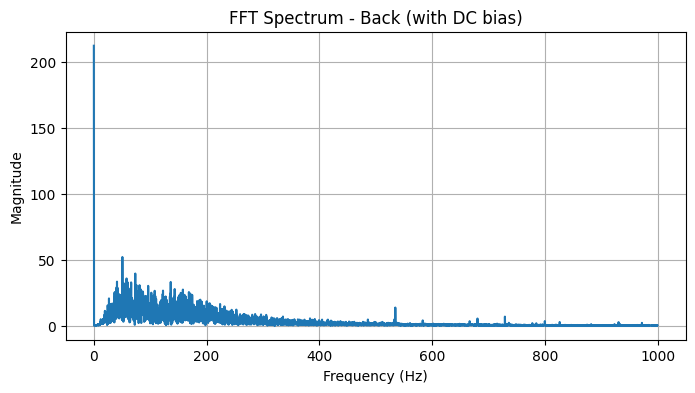

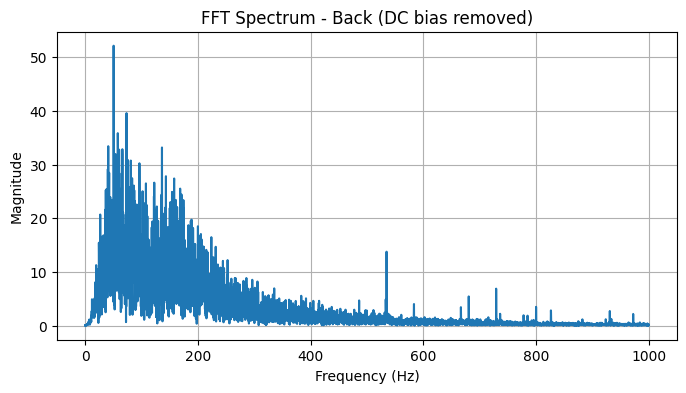

Back: Max Mean Amplitude = 0.0735 at index 4019

*** Processing Trial 1 ***


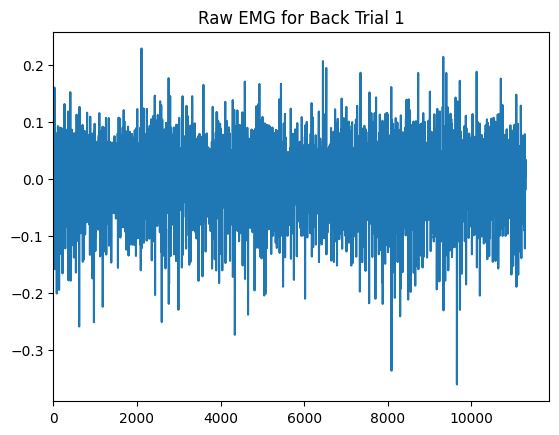

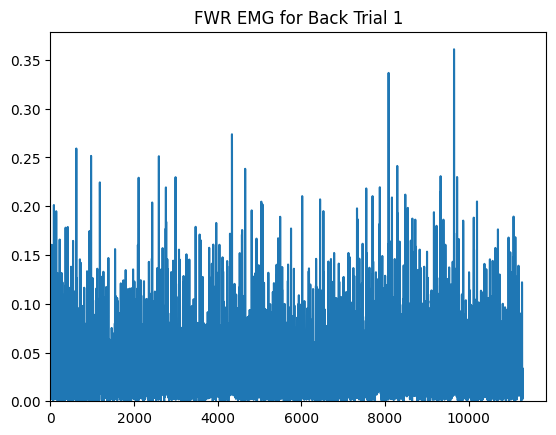

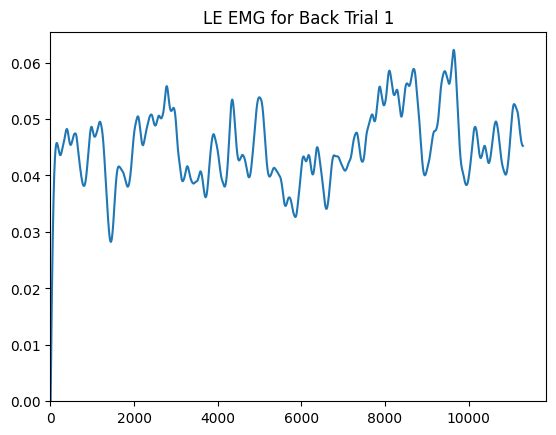

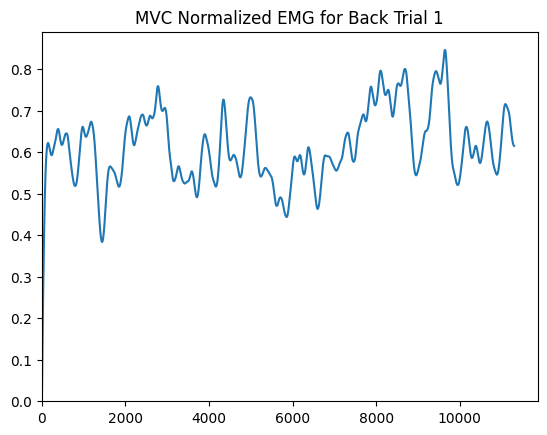

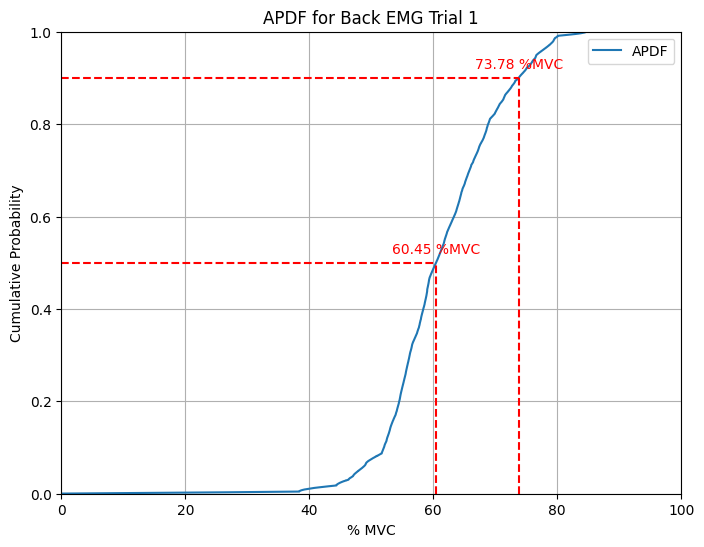

In [9]:
def main():
    fs = float(input("Enter the sampling frequency (Hz): "))
    order = int(input("Enter the desired filter order (e.g., 2): "))
    cutoff = float(input("Enter the desired cutoff frequency (Hz) (e.g., 6): "))
    
    # Prompt for file paths and other parameters
    print("Enter the file paths and column names for your EMG data processing.")
    mvc_file = get_file_path("Enter the full path for the MVC CSV file: ")
    
    num_trials = int(input("Enter the number of trial files: "))
    trial_files = [get_file_path(f"Enter the full path for trial file {i+1}: ")
                   for i in range(num_trials)]
    
    num_muscles = int(input("Enter the number of muscle groups: "))
    muscle_info = {}
    for i in range(num_muscles):
        muscle_name = input(f"Enter the name for muscle {i+1} (e.g., Back): ").strip()
        mvc_col = input(f"Enter the MVC CSV column header for {muscle_name}: ").strip()
        trial_col = input(f"Enter the trial CSV column header for {muscle_name} (if same as MVC, repeat): ").strip()
        muscle_info[muscle_name] = {"mvc": mvc_col, "trial": trial_col}
    
    force_col = input("Enter the force column header in the MVC file (for onset detection): ").strip()
    
    # Prompt for APDF percentiles
    num_percentiles = int(input("Enter the number of percentiles to visualize in the APDF: "))
    percentiles = [float(input(f"Enter percentile {i+1}: ")) for i in range(num_percentiles)]
    
    # Read the MVC data file
    emg_mvc = pd.read_csv(mvc_file)
    
    # Process MVC trial
    mvc_filtered, mvc_max_amplitudes = process_mvc(emg_mvc, muscle_info, force_col, fs, cutoff, order)
    
    # Process each trial file
    trial_results = process_trials(trial_files, muscle_info, mvc_max_amplitudes, fs, cutoff, order)
    
    # Generate and plot APDFs
    plot_apdf(trial_results, percentiles)
    
if __name__ == "__main__":
    main()

### Conclusion

To summarize, this program is designed to process raw EMG data according to best practices from a user-specified amount of files to yield MVC normalized EMG visualized in APDFs. 

Some considerations at this time to ensure the program functions properly are that the raw EMG data must be stored in a specific manner (example attached in repository):

    1) Data must be stored in a .csv file

    2) Raw EMG data must be stored column-wise, with the first row of the file corresponding to the column-headers
    
However, despite the required file formatting this program code is relatively user-friendly where it walks you through the required information needed to take raw EMG to MVC normalized EMG in the form of APDFs.